In [1]:
# ==============================================================
# 04 - MODELLING: REGRESIÓN (PIB ↔ Esperanza de Vida)
# ==============================================================

# --- Imports mínimos necesarios ---
import os, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --------------------------------------------------------------
# 0) Cargar 'df' (Kedro si está disponible, si no CSV local)
# --------------------------------------------------------------
df = None
try:
    from kedro.framework.session import KedroSession
    session = KedroSession.create("..")
    context = session.load_context()
    catalog = context.catalog
    print("Kedro listo ✅")

    df = catalog.load("merged_data")
    print(f"✅ merged_data cargado desde catálogo: {df.shape}")
except Exception as e:
    print("⚠️ Kedro no disponible o 'merged_data' no existe en catálogo.")
    # Ruta local de respaldo
    local_path = "../data/03_primary/merged_data.csv"
    df = pd.read_csv(local_path)
    print(f"✅ CSV local cargado: {df.shape} ({local_path})")



[11/01/25 22:25:38] INFO     Kedro is sending anonymous usage data with the sole purpose of improving ]8;id=673342;file://C:\Users\Gamer\Desktop\Machine_learning\proyectomachinelearning\venv\Lib\site-packages\kedro_telemetry\plugin.py\plugin.py]8;;\:]8;id=595860;file://C:\Users\Gamer\Desktop\Machine_learning\proyectomachinelearning\venv\Lib\site-packages\kedro_telemetry\plugin.py#243\243]8;;\
                             the product. No personal data or IP addresses are stored on our side. To              
                             opt out, set the `KEDRO_DISABLE_TELEMETRY` or `DO_NOT_TRACK` environment              
                             variables, or create a `.telemetry` file in the current working                       
                             directory with the contents `consent: false`. To hide this message,                   
                             explicitly grant or deny consent. Read more at                                        
                             https://docs.kedro.org/en/stable/configuration/telemetry.html                         

Kedro listo ✅


[11/01/25 22:25:39] INFO     Loading data from merged_data (CSVDataSet)...                      ]8;id=844124;file://C:\Users\Gamer\Desktop\Machine_learning\proyectomachinelearning\venv\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=881933;file://C:\Users\Gamer\Desktop\Machine_learning\proyectomachinelearning\venv\Lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

✅ merged_data cargado desde catálogo: (6976, 14)


In [2]:

# --------------------------------------------------------------
# 2️⃣ Función auxiliar de evaluación
# --------------------------------------------------------------
def evaluar_modelo(nombre, y_true, y_pred):
    return {
        "Modelo": nombre,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred),
    }

In [3]:
# --------------------------------------------------------------
# 1) Preparación de los datos
# --------------------------------------------------------------
target = "period_life_expectancy_at_birth"
features = ["gdp_per_capita", "gdp_variation", "year"]

# Limpieza mínima
dfm = df.copy()
dfm = dfm.dropna(subset=[target] + features)

X = dfm[features]
y = dfm[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Datos listos → X_train: {X_train.shape}, X_test: {X_test.shape}")


Datos listos → X_train: (5493, 3), X_test: (1374, 3)


In [4]:
# === GridSearchCV para Random Forest (Regresión) ===
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [8, 10, 12],
    "min_samples_split": [2, 5, 8],
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    refit=True,
)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
pred_best = best_rf.predict(X_test)

print("Mejor RF:", grid_rf.best_params_)
print("R2:", r2_score(y_test, pred_best), "| RMSE:", np.sqrt(mean_squared_error(y_test, pred_best)))


Mejor RF: {'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 300}
R2: 0.6361448888611128 | RMSE: 6.870023398288965


In [8]:
# --------------------------------------------------------------
# 2) Helpers
# --------------------------------------------------------------
def evaluar_modelo(nombre, y_true, y_pred):
    return {
        "Modelo": nombre,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred),
    }

resultados = []


In [9]:

# --------------------------------------------------------------
# 3) Entrenamiento de 5 modelos
# --------------------------------------------------------------
# 1) Regresión Lineal
lr = LinearRegression().fit(X_train, y_train)
pred_lr = lr.predict(X_test)
resultados.append(evaluar_modelo("Regresión Lineal", y_test, pred_lr))

# 2) Ridge
ridge = Ridge(alpha=1.0).fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)
resultados.append(evaluar_modelo("Regresión Ridge", y_test, pred_ridge))

# 3) Lasso
lasso = Lasso(alpha=0.001, max_iter=5000).fit(X_train, y_train)
pred_lasso = lasso.predict(X_test)
resultados.append(evaluar_modelo("Regresión Lasso", y_test, pred_lasso))

# 4) Decision Tree
dt = DecisionTreeRegressor(max_depth=8, min_samples_split=10, random_state=42).fit(X_train, y_train)
pred_dt = dt.predict(X_test)
resultados.append(evaluar_modelo("Decision Tree", y_test, pred_dt))

# 5) Random Forest
rf = RandomForestRegressor(
    n_estimators=500, max_depth=12, min_samples_split=5,
    random_state=42, n_jobs=-1
).fit(X_train, y_train)
pred_rf = rf.predict(X_test)
resultados.append(evaluar_modelo("Random Forest", y_test, pred_rf))



In [10]:
# --------------------------------------------------------------
# 4) Resultados comparativos
# --------------------------------------------------------------
resultados_df = pd.DataFrame(resultados).sort_values("RMSE").reset_index(drop=True)
display(resultados_df)

ganador = resultados_df.iloc[0]["Modelo"]
print(f"\n🏆 Mejor modelo: {ganador}")

# Predicciones del ganador (para gráfica y guardado)
pred_map = {
    "Regresión Lineal": pred_lr,
    "Regresión Ridge": pred_ridge,
    "Regresión Lasso": pred_lasso,
    "Decision Tree": pred_dt,
    "Random Forest": pred_rf,
}
pred_best = pred_map[ganador]


,Modelo,MAE,RMSE,R²
0,Random Forest,5.137926,6.947701,0.627870
1,Decision Tree,5.283770,7.238674,0.596048
2,Regresión Lasso,7.924234,9.524718,0.300615
3,Regresión Ridge,7.924233,9.524718,0.300615
4,Regresión Lineal,7.924233,9.524718,0.300615



🏆 Mejor modelo: Random Forest


In [11]:
# --------------------------------------------------------------
# 🔧 OPTIMIZACIÓN: GridSearchCV para Random Forest
# --------------------------------------------------------------
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 300],
    "max_depth": [8, 10, 12],
    "min_samples_split": [2, 5, 8],
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    refit=True,
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
pred_best = best_rf.predict(X_test)

print("Mejor RF (GridSearch):", grid_rf.best_params_)
print("R2:", r2_score(y_test, pred_best), "| RMSE:", np.sqrt(mean_squared_error(y_test, pred_best)))


Mejor RF (GridSearch): {'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 300}
R2: 0.6361448888611128 | RMSE: 6.870023398288965


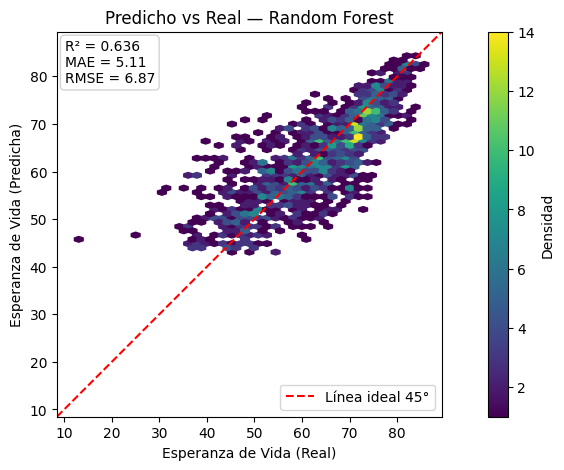

In [12]:
# --------------------------------------------------------------
# 5) Gráfica Predicho vs Real (hexbin + línea 45°)
# --------------------------------------------------------------
r2  = r2_score(y_test, pred_best)
mae = mean_absolute_error(y_test, pred_best)
rmse = np.sqrt(mean_squared_error(y_test, pred_best))

ymin = min(y_test.min(), pred_best.min())
ymax = max(y_test.max(), pred_best.max())
pad = (ymax - ymin) * 0.05
ymin, ymax = ymin - pad, ymax + pad

plt.figure(figsize=(12,5))
hb = plt.hexbin(y_test, pred_best, gridsize=40, cmap="viridis", mincnt=1)
plt.colorbar(hb, label="Densidad")
plt.plot([ymin, ymax], [ymin, ymax], 'r--', lw=1.5, label="Línea ideal 45°")
plt.xlim(ymin, ymax); plt.ylim(ymin, ymax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f"Predicho vs Real — {ganador}")
plt.xlabel("Esperanza de Vida (Real)")
plt.ylabel("Esperanza de Vida (Predicha)")
plt.legend(loc="lower right")
# Métricas en caja
plt.text(0.02, 0.98, f"R² = {r2:.3f}\nMAE = {mae:.2f}\nRMSE = {rmse:.2f}",
         transform=plt.gca().transAxes, va="top", ha="left",
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.85, edgecolor="#ccc"))
plt.show()

In [13]:
# --------------------------------------------------------------
# 6️⃣ Guardado (métricas y mejor modelo optimizado)
# --------------------------------------------------------------
import joblib
from datetime import datetime

os.makedirs("../data/07_model_output", exist_ok=True)
os.makedirs("../data/06_models", exist_ok=True)
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Guardar las métricas del modelo optimizado (GridSearch)
res_reg = pd.DataFrame([{
    "Modelo": "RandomForest (GridSearch)",
    "R2": r2_score(y_test, pred_best),
    "RMSE": np.sqrt(mean_squared_error(y_test, pred_best)),
    "MAE": mean_absolute_error(y_test, pred_best),
    "params": grid_rf.best_params_
}])

metrics_path = f"../data/07_model_output/regression_metrics_{stamp}.csv"
res_reg.to_csv(metrics_path, index=False)

# Guardar el modelo optimizado
model_path = f"../data/06_models/best_regression_model_RandomForest.pkl"
joblib.dump(best_rf, model_path)

print(f"✅ Métricas guardadas en: {metrics_path}")
print(f"✅ Modelo optimizado guardado en: {model_path}")
print(f"🏆 R² = {r2_score(y_test, pred_best):.3f} | RMSE = {np.sqrt(mean_squared_error(y_test, pred_best)):.2f}")


✅ Métricas guardadas en: ../data/07_model_output/regression_metrics_20251101-222650.csv
✅ Modelo optimizado guardado en: ../data/06_models/best_regression_model_RandomForest.pkl
🏆 R² = 0.636 | RMSE = 6.87


In [10]:
# --------------------------------------------------------------
# 7) Conclusión breve (lista para informe)
# --------------------------------------------------------------
print("\n📌 Conclusión:")
print(f"- Probamos 5 modelos (lineales y de árboles).")
print(f"- El mejor fue {ganador} con R² = {r2:.3f}, MAE = {mae:.2f} y RMSE = {rmse:.2f}.")
print("- El PIB per cápita y el año explican una parte relevante de la esperanza de vida,")
print("  pero para mejorar el ajuste se sugiere incorporar variables sociales/sanitarias.")


📌 Conclusión:
- Probamos 5 modelos (lineales y de árboles).
- El mejor fue Random Forest con R² = 0.628, MAE = 5.14 y RMSE = 6.95.
- El PIB per cápita y el año explican una parte relevante de la esperanza de vida,
  pero para mejorar el ajuste se sugiere incorporar variables sociales/sanitarias.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 from kedro.framework.session import KedroSession                                            │
│    2                                                                                             │
│    3 # Crea una sesión Kedro dentro del proyecto actual                                          │
│ ❱  4 session = KedroSession.create("..")                                                         │
│    5 context = session.load_context()                                                            │
│    6                                                                                             │
│    7 # Carga el dataset con las métricas                                                         │
│                                                                                                  │
│ c:\Users\Gamer\Desktop\Machine_learning\Proyectomachinelearning\venv\Lib\site-packages\kedro\fra │
│ mework\session\session.py:154 in create                                                          │
│                                                                                                  │
│   151 │   │   Returns:                                                                           │
│   152 │   │   │   A new ``KedroSession`` instance.                                               │
│   153 │   │   """                                                                                │
│ ❱ 154 │   │   validate_settings()                                                                │
│   155 │   │                                                                                      │
│   156 │   │   session = cls(                                                                     │
│   157 │   │   │   project_path=project_path,                                                     │
│                                                                                                  │
│ c:\Users\Gamer\Desktop\Machine_learning\Proyectomachinelearning\venv\Lib\site-packages\kedro\fra │
│ mework\project\__init__.py:311 in validate_settings                                              │
│                                                                                                  │
│   308 │   More info on the dynaconf issue: https://github.com/dynaconf/dynaconf/issues/460       │
│   309 │   """                                                                                    │
│   310 │   if PACKAGE_NAME is None:                                                               │
│ ❱ 311 │   │   raise ValueError(                                                                  │
│   312 │   │   │   "Package name not found. Make sure you have configured the project using "     │
│   313 │   │   │   "'bootstrap_project'. This should happen automatically if you are using "      │
│   314 │   │   │   "Kedro command line interface."                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: Package name not found. Make sure you have configured the project using 'bootstrap_project'. This 
should happen automatically if you are using Kedro command line interface.